In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import sklearn
from IPython.core.interactiveshell import InteractiveShell; InteractiveShell.ast_node_interactivity = "all"
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, SGDRegressor, Ridge, Lasso, ElasticNet, TweedieRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import shap
from sklearn.inspection import permutation_importance
import xgboost

In [2]:
path = 'Case Study[100]/Analytics Case Study/dummy_data.csv'
df = pd.read_csv(path)

# EDA on the given dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   id                       382154 non-null  int64 
 1   Gender                   382154 non-null  object
 2   Age                      382154 non-null  int64 
 3   Driving_License          382154 non-null  int64 
 4   Region_Code              382154 non-null  int64 
 5   Previously_Insured       382154 non-null  int64 
 6   Vehicle_Age              382154 non-null  object
 7   Previous_Vehicle_Damage  382154 non-null  object
 8   Annual_Premium           382154 non-null  int64 
 9   Policy_Sales_Channel     382154 non-null  int64 
 10  Response                 382154 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 32.1+ MB


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Previous_Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
0,167647,Male,22,1,7,1,< 1 Year,No,2630,152,0
1,17163,Male,42,1,28,0,1-2 Year,Yes,43327,26,0
2,32023,Female,66,1,33,0,1-2 Year,Yes,35841,124,0
3,87447,Female,22,1,33,0,< 1 Year,No,27645,152,0
4,501933,Male,28,1,46,1,< 1 Year,No,29023,152,0


,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Response
count,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000
mean,234392.953477,38.545691,0.998108,26.406867,0.489182,30711.271362,111.939812,0.163811
std,139527.487326,15.226897,0.043455,13.181241,0.499884,17061.595532,54.286511,0.370104
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,0.000000
25%,115006.250000,25.000000,1.000000,15.000000,0.000000,24546.000000,26.000000,0.000000
50%,230461.500000,36.000000,1.000000,28.000000,0.000000,31692.000000,145.000000,0.000000
75%,345434.750000,49.000000,1.000000,35.000000,1.000000,39447.750000,152.000000,0.000000
max,508145.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,1.000000


,# missing
column,
id,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Previous_Vehicle_Damage,0
Annual_Premium,0


Annual_Premium                       
                                  mean   median           std
Previous_Vehicle_Damage                                      
No                        30501.230311  30969.0  15932.035066
Yes                       30938.293837  32617.0  18201.148113

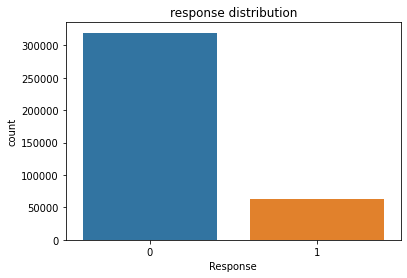

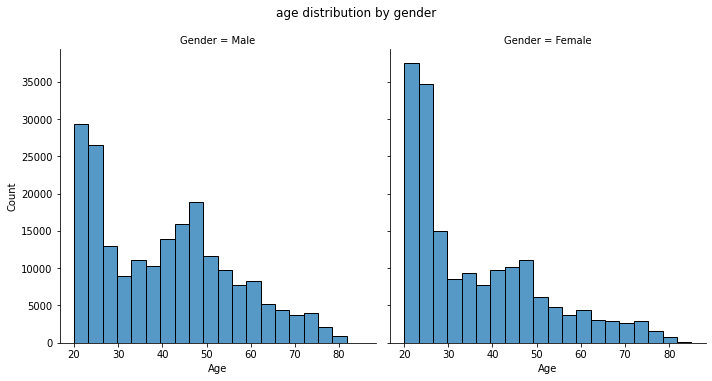

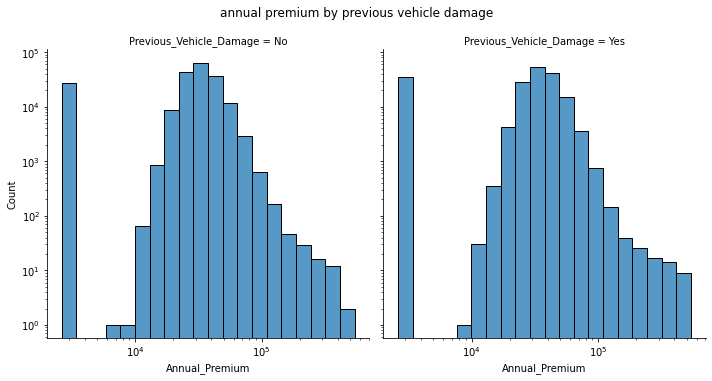

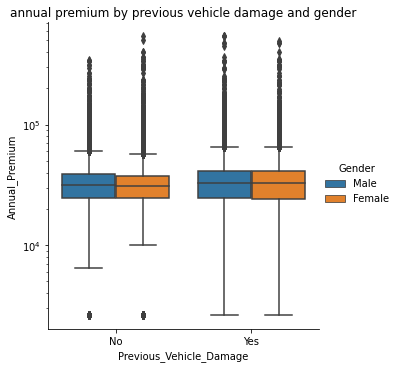

In [3]:
df.info() # `Gender`, `Vehicle_Age`, `Previous_Vehicle_Damage` are non-numeric

df.head() # have a look at our dataset first

df.describe() # check the summary statistics for the numeric columns

# check if there are missing values for each feature
df.isna().sum().rename_axis('column').rename('# missing').to_frame() 

_ = sns.countplot(data=df, x='Response').set(title='response distribution')

_ = sns.displot(data=df, x='Age', col='Gender', bins=20).figure.suptitle("age distribution by gender", y=1.05)

# check whether people with previous vehicle damage will pay a higher premium
df.groupby(['Previous_Vehicle_Damage'])[['Annual_Premium']].agg(['mean','median','std'])

_ = sns.displot(data=df, x='Annual_Premium', col='Previous_Vehicle_Damage', bins=20, log_scale=(True,True)).figure.suptitle("annual premium by previous vehicle damage", y=1.05)

_ = sns.catplot(data=df, y='Annual_Premium', x='Previous_Vehicle_Damage', hue='Gender', kind='box').set(yscale='log').set(title='annual premium by previous vehicle damage and gender')

,Gender,Vehicle_Age,Previous_Vehicle_Damage
0,Male,< 1 Year,No
1,Male,1-2 Year,Yes
2,Female,1-2 Year,Yes
3,Female,< 1 Year,No
4,Male,< 1 Year,No


,Gender,Vehicle_Age,Previous_Vehicle_Damage
count,382154,382154,382154
unique,2,3,2
top,Male,1-2 Year,No
freq,205603,200176,198501


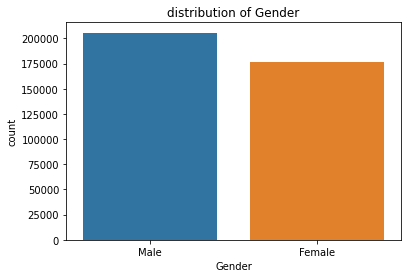

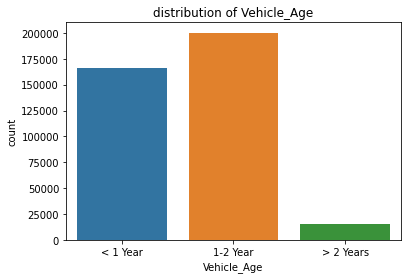

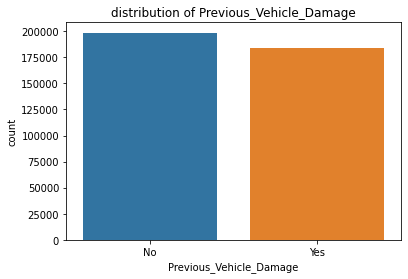

In [4]:
# show the non-numeric columns. These columns will need to be transformed

# select all non-numeric columns and have a look
df.select_dtypes(exclude='number').head()

# show the number of unique values for each non-numeric column
df.describe(include='object')
# df.select_dtypes(exclude='number').nunique()

for col in df.select_dtypes(exclude='number').columns:
    _ = plt.figure()
    _ = sns.countplot(data=df, x=col).set(title=f"distribution of {col}")


number of unique values for `Region_Code` = 53


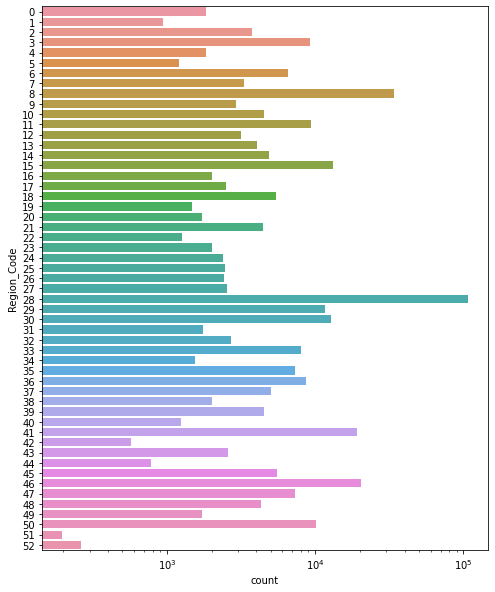

In [5]:
# although `Region_Code` and `Policy_Sales_Channel` are numeric, they are actually nominal variables encoded in integers. We need to examine them as well

print(f"number of unique values for `Region_Code` = {df.Region_Code.nunique()}")  # check how many unique values there are for `Region_Code`
_ = sns.countplot(data=df, y='Region_Code', figure=plt.figure(figsize=(8,10))).set(xscale='log')

In [6]:
print(f"number of unique values for `Policy_Sales_Channel` = {df.Policy_Sales_Channel.nunique()}") # check how many unique values there are for `Policy_Sales_Channel` 

df.Policy_Sales_Channel.value_counts().sort_values().rename_axis('channel').rename('count').to_frame().head(20) # it seems many Policy_Sales_Channel has very low count

number of unique values for `Policy_Sales_Channel` = 156


,count
channel,
143,1
141,1
41,1
149,1
50,1
144,1
84,1
123,2
75,2


In [7]:
# find each channel's proportion
channel_prop = (
    df
    .Policy_Sales_Channel
    .value_counts(normalize=True)
    .sort_values(ascending=False)
    .rename_axis('Channel')
    .rename('proportion')
)

# find cumulative channel proportion 
channel_cum = channel_prop.cumsum().rename('cumulative proportion')

# concat the proportion and cumulative proportion 
# the reocrds are mostly in the first few channels.
pd.concat([channel_prop, channel_cum], axis=1).head(10)

# find all channels with proportion < 0.02
# we will replace all channels with proportion < 0.02 by `others`. That is, group all of those channels into one group called `others`
channel_replace = channel_prop.iloc[channel_prop.gt(0.02).argmin()+1:].index

print("Channels to be grouped together: ")
channel_replace

,proportion,cumulative proportion
Channel,,
152,0.359598,0.359598
26,0.213438,0.573036
124,0.191847,0.764883
160,0.055069,0.819952
156,0.026445,0.846397
122,0.025500,0.871897
157,0.017634,0.889531
154,0.015394,0.904926
151,0.009839,0.914765


Channels to be grouped together: 


Int64Index([154, 151, 163,  25,  13,   7,   8,  30, 155,  55,
            ...
             75, 123, 112, 141,  41,  84,  50, 144, 149, 143],
           dtype='int64', name='Channel', length=149)

# data engineering
We do the following to transform our dataset:
- drop `Response` and `id` variables, because the former is target `y` and latter is not a useful feature
- encode `Gender`, `Previous_Vehicle_Damage` and `Vehicle_Age` to numeric variables
- for `Policy_Sales_Channel`, map all values with less than 0.02 proportion of occurrence to `others`
- rename `Gender` to `Gender_Male`
- one-hot encode `Region_Code` and `Policy_Sales_Channel`
- standardization of the data


In [16]:
# we need to do the following:
# - drop response 
X = (
      df
      .drop(['Response', 'id'], axis=1)
      .replace({
            'Gender': {'Male':1, 'Female':0},
            'Previous_Vehicle_Damage': {'Yes':1, 'No':0},
            'Vehicle_Age': {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2},
            'Policy_Sales_Channel': dict.fromkeys(channel_replace, 'others'),
            })
      .rename({
            'Gender':'Gender_Male', 
            }, axis=1)
      .pipe(pd.get_dummies, prefix='Region_Code', columns=['Region_Code'])
      .pipe(pd.get_dummies, prefix='Policy_Sales_Channel', columns=['Policy_Sales_Channel'])
      .pipe(lambda df: df.subtract(df.mean()).div(df.std()))
)

In [17]:
y = df.Response # y is the target variable

In [18]:
# create smaller subsets for testing code only
sample_id = np.random.choice(X.index, size=100_00, replace=False)
X_reduce, y_reduce = X.loc[sample_id], y.loc[sample_id]

# sanity check after data engineering

In [19]:
print(f"{df.shape = }")
print(f"{X.shape = }")

# make sure after transformation, no more non-numeric columns
print(f"number of non-numeric columns = {X.select_dtypes(exclude='number').columns.size}") 

# check if there are missing values in the entire dataset
print(f"number of missing entries = {X.isna().sum().sum()}")

# mean should be 0 for each feature
print(f"mean of each feature equal 0? {np.allclose(X.mean(), 0) }")

# standard deviation should be 1 for each feature
print(f"standard deviation of each feature equal 1? {np.allclose(X.std(), 1) }")

df.shape = (382154, 11)
X.shape = (382154, 68)
number of non-numeric columns = 0
number of missing entries = 0
mean of each feature equal 0? True
standard deviation of each feature equal 1? True


# modelling

## build logistic regression and check the coefficient values as feature importance

In [ ]:
model = RandomizedSearchCV(
    LogisticRegression(),
    {'C':np.arange(0.001, 1, 0.01), 'class_weight':['balanced', None]},
    n_iter=20,
    scoring = 'roc_auc',
    cv=3
)
model.fit(X,y)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091, 0.101, 0.111, 0.121, 0.131, 0.141, 0.151, 0.161, 0.171,
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0...
       0.451, 0.461, 0.471, 0.481, 0.491, 0.501, 0.511, 0.521, 0.531,
       0.541, 0.551, 0.561, 0.571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791, 0.801,
       0.811, 0.821, 0.831, 0.841, 0.851, 0.861, 0.871, 0.881, 0.891,
       0.901, 0.911, 0.921, 0.931, 0.941, 0.951, 0.961, 0.971, 0.981,
       0.991]),
                                        'class_weight': ['balanced', None]},
                   scoring='roc_auc')

In [ ]:
# print("model hyperparameters: ")
# model.best_estimator_.get_params()

In [24]:
X.Previous_Vehicle_Damage.value_counts()

-0.961872    198501
 1.039637    183653
Name: Previous_Vehicle_Damage, dtype: int64

In [ ]:
logistic_feat_importance = pd.Series(
    data = model.best_estimator_.coef_[-1], index=X.columns
).sort_values(ascending=False, key=abs)

print("top 20 features sorted by feature importance (negative means negatively correlates with claim)")
logistic_feat_importance.head(20)
print("bottom 10 features sorted by feature importance (negative means negatively correlates with claim)")
logistic_feat_importance.tail(10)

top 20 features sorted by feature importance (negative means negatively correlates with claim)


Previously_Insured            -2.089246
Previous_Vehicle_Damage        1.205749
Age                           -0.566196
Policy_Sales_Channel_152      -0.497582
Policy_Sales_Channel_160      -0.457928
Policy_Sales_Channel_26        0.380308
Policy_Sales_Channel_124       0.257341
Vehicle_Age                    0.231974
Policy_Sales_Channel_others    0.157505
Policy_Sales_Channel_157       0.101636
Region_Code_48                -0.101299
Region_Code_50                -0.098932
Region_Code_0                 -0.084603
Policy_Sales_Channel_122       0.083515
Region_Code_29                 0.076743
Region_Code_41                 0.074548
Region_Code_28                 0.065086
Policy_Sales_Channel_156       0.063397
Region_Code_11                 0.063139
Region_Code_25                -0.062642
dtype: float64

bottom 10 features sorted by feature importance (negative means negatively correlates with claim)


Region_Code_45    0.005401
Region_Code_13   -0.005275
Region_Code_33    0.005168
Region_Code_32    0.005105
Region_Code_12   -0.004161
Region_Code_7    -0.002747
Region_Code_51    0.001592
Region_Code_46    0.001448
Region_Code_19   -0.000350
Region_Code_52    0.000214
dtype: float64

## use permutation importance to find feature importance

In [ ]:
# estimator = RandomForestClassifier(max_depth=3, n_estimators=50, class_weight='balanced').fit(X,y)
# perm = permutation_importance(estimator, X, y, scoring='roc_auc', n_repeats=2)
# perm.importances_mean

In [ ]:
estimator = RandomForestClassifier(max_depth=3, n_estimators=50, class_weight='balanced')

# perm = PermutationImportance(estimator, scoring='roc_auc', cv=3, n_iter=10).fit(X_reduce.values, y_reduce.values)
perm = PermutationImportance(estimator, scoring='roc_auc', cv=3, n_iter=10).fit(X.values, y.values)

In [50]:
eli5.show_weights(perm, feature_names=X.columns.to_list(), top=None, include_styles=False)

Weight,Feature
0.0624 ± 0.0580,Previous_Vehicle_Damage
0.0567 ± 0.0465,Previously_Insured
0.0151 ± 0.0054,Age
0.0110 ± 0.0035,Policy_Sales_Channel_152
0.0046 ± 0.0028,Vehicle_Age
0.0039 ± 0.0017,Policy_Sales_Channel_26
0.0023 ± 0.0019,Policy_Sales_Channel_160
0.0018 ± 0.0012,Policy_Sales_Channel_124
0.0013 ± 0.0017,Region_Code_28
0.0006 ± 0.0006,Policy_Sales_Channel_157


## use SHAP value as feature importance

In [156]:
# estimator = RandomForestClassifier(max_depth=3, n_estimators=50, class_weight='balanced').fit(X_reduce, y_reduce)
estimator = RandomForestClassifier(max_depth=3, n_estimators=50, class_weight='balanced').fit(X, y)
explainer = shap.Explainer(estimator, X)

shap_values = explainer(X)

100%|===================| 763236/764308 [05:40<00:00]        

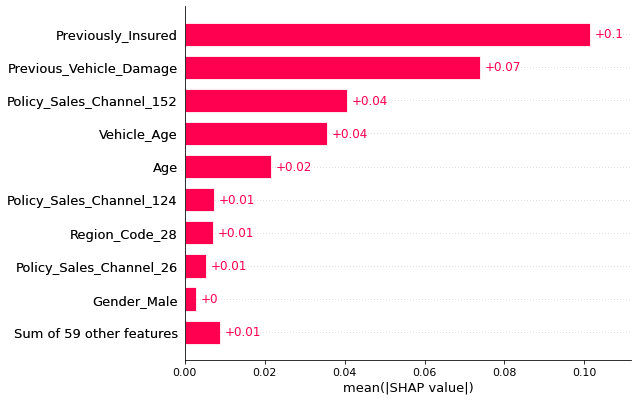

In [157]:
shap.plots.bar(shap_values[:,:,1])

In [158]:
shap_df = pd.DataFrame(shap_values.values[:,:,0], columns=X.columns)
vals = np.abs(shap_df.values).mean(0)
shap_importance = pd.DataFrame(list(zip(X.columns, vals)), columns=['col_name', 'feature_importance_vals'])
shap_importance.sort_values('feature_importance_vals', ascending=False).head(7)

,col_name,feature_importance_vals
3,Previously_Insured,0.101350
5,Previous_Vehicle_Damage,0.073885
63,Policy_Sales_Channel_152,0.040560
4,Vehicle_Age,0.035622
1,Age,0.021540
62,Policy_Sales_Channel_124,0.007374
35,Region_Code_28,0.007069


# summary
- Our models suggest the following as important features in predicting claims:
    - `Previously_Insured`       (negative impact)
    - `Vehicle_Age`              (positive impact)
    - `Previous_Vehicle_Damage`  (positive impact)
    - `Age`                      (negative impact)
    - `Policy_Sales_Channel_152` (negative impact)
    - `Policy_Sales_Channel_160` (negative impact)
    - `Policy_Sales_Channel_26 ` (positive impact)
    - `Policy_Sales_Channel_124` (positive impact)